In [1]:
% run __initialize.ipynb
import pyspark

In [140]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col, concat, lit, when, date_format, unix_timestamp, monotonically_increasing_id, floor
from pyspark.sql.types import Row, ArrayType, BooleanType, DateType, DecimalType, DoubleType, IntegerType, NumericType, StringType, MapType
def spark_udf(spark_type):
    def function_decorator(func):
        return F.UserDefinedFunction(func, spark_type)
    return function_decorator

In [120]:
sdf= spark.read.option('header','true')\
    .option('inferSchema','true')\
    .csv('data/household_power_consumption.txt', sep=';')\
    .limit(1000)
sdf = sdf.select('Date','Time',
                 sdf.Global_active_power.cast(DoubleType()), 
                 sdf.Global_reactive_power.cast(DoubleType()))\
         .withColumn('bin', floor(monotonically_increasing_id()/100.))\
         .filter(F.rand() < 0.5)
         
sdf.registerTempTable('power')

In [118]:
sdf.count()

497

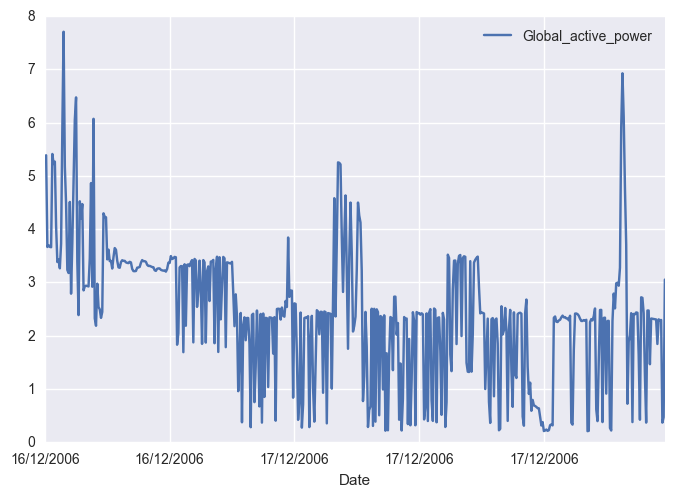

In [121]:
df = sdf.toPandas()
df.plot('Date','Global_active_power')

In [82]:
%config SQLConn.conn_object_name = 'spark'

In [83]:
%%readsql
SELECT *
FROM power
LIMIT 10

,Date,Time,Global_active_power,Global_reactive_power,bin
0,16/12/2006,17:24:00,4.216,0.418,0
1,16/12/2006,17:25:00,5.360,0.436,0
2,16/12/2006,17:26:00,5.374,0.498,0
3,16/12/2006,17:27:00,5.388,0.502,0
4,16/12/2006,17:28:00,3.666,0.528,0
5,16/12/2006,17:29:00,3.520,0.522,0
6,16/12/2006,17:30:00,3.702,0.520,0
7,16/12/2006,17:31:00,3.700,0.520,0
8,16/12/2006,17:32:00,3.668,0.510,0
9,16/12/2006,17:33:00,3.662,0.510,0


In [88]:
n = len(sdf.select("Date").first()[0])
n

10

In [ ]:
F.collect_list()

In [107]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,bin
0,16/12/2006,17:24:00,4.216,0.418,0
1,16/12/2006,17:25:00,5.360,0.436,0
2,16/12/2006,17:26:00,5.374,0.498,0
3,16/12/2006,17:27:00,5.388,0.502,0
4,16/12/2006,17:28:00,3.666,0.528,0


In [137]:
a = {1:2}
for i in a.items():
    print(i)

(1, 2)


In [194]:
from pyspark.sql.functions import mean, hour, array

agg_functions = {'min': np.min, 'max': np.max, 'mean': np.mean, 'sum': np.sum, 'median': np.median}
DECAY_FACTOR = 60.*60

@spark_udf(MapType(StringType(), DoubleType()))
def exp_rolling(ref_pt, past_events, decay):
    decay = float(decay)
    ref_pt = pd.to_datetime(ref_pt)
    df = pd.to_datetime(past_events)
    time_diff = (ref_pt - df).seconds
    exp_time_diff = np.exp(-time_diff/decay)
    results = {}
    for k,func in agg_functions.items():
        results[k] = float(func(exp_time_diff))
    return results

sdf2 = sdf.limit(500)\
    .groupby('bin')\
    .agg(F.max('Time').alias('ref_pt'), F.collect_list('Time').alias('time_array'), F.count('Time').alias('num_observations'))\
    .select('*', exp_rolling('ref_pt', 'time_array', F.lit(DECAY_FACTOR)).alias('exp_aggs'))\
    .select('*', *[col('exp_aggs')[i].alias('exp_aggs_' + i) for i in agg_functions.keys()])\
    .drop('exp_aggs')
#     .toPandas()
# select(exp_rolling(col('Date'),col('Global_active_power'))).toPandas()

In [192]:
sdf2.toPandas()

,bin,ref_pt,time_array,num_observations,exp_aggs_sum,exp_aggs_mean,exp_aggs_min,exp_aggs_max,exp_aggs_median
0,0,19:03:00,"[17:25:00, 17:27:00, 17:28:00, 17:31:00, 17:32...",51,46.642993,0.914568,0.849308,1.0,0.910890
1,1,20:43:00,"[19:07:00, 19:10:00, 19:17:00, 19:24:00, 19:25...",49,45.759308,0.933863,0.852144,1.0,0.940196
2,2,22:18:00,"[20:44:00, 20:46:00, 20:49:00, 20:50:00, 20:52...",57,52.857978,0.927333,0.854989,1.0,0.929291
3,3,23:56:00,"[22:29:00, 22:31:00, 22:32:00, 22:34:00, 22:35...",40,37.081368,0.927034,0.865022,1.0,0.926200
4,4,01:41:00,"[00:04:00, 00:05:00, 00:09:00, 00:10:00, 00:11...",55,50.651066,0.920928,0.850725,1.0,0.921579
5,5,03:23:00,"[01:46:00, 01:47:00, 01:53:00, 01:54:00, 02:02...",34,31.262082,0.919473,0.850725,1.0,0.920812
6,6,05:01:00,"[03:24:00, 03:25:00, 03:26:00, 03:27:00, 03:28...",56,51.811681,0.925209,0.850725,1.0,0.927745
7,7,06:43:00,"[05:05:00, 05:06:00, 05:09:00, 05:10:00, 05:13...",53,48.985090,0.924247,0.849308,1.0,0.927743
8,8,08:21:00,"[06:44:00, 06:48:00, 06:49:00, 06:50:00, 06:52...",50,46.310342,0.926207,0.850725,1.0,0.926997
9,9,10:03:00,"[08:25:00, 08:26:00, 08:29:00, 08:33:00, 08:35...",53,49.228638,0.928842,0.849308,1.0,0.930841


In [166]:
sdf2\
    .select([col('udf')[i].alias('udf_' + i) for i in ['min', 'max']])

DataFrame[udf_min: double, udf_max: double]

In [168]:
[k for k in sdf2.udf.]

TypeError: Column is not iterable